# Plasma Volume Dataset Preparation

## Introduction

This notebook demonstrates using the FAIR-MAST API to download and prepare datasets for the Data Science Challenges. The download process accommodates the large file sizes of Plasma Volume and Equilibrium challenge files that exceed standard git repository limits. These steps showcase common data preparation techniques for real-world machine learning projects.

By studying the API commands alongside the [FAIR-MAST](https://mastapp.site/) documentation, you can extend these examples to build better inference engines and explore MAST data to create your own tools.

## Purpose

This notebook will:
1. Demonstrate FAIR-MAST data access methods
2. Download datasets for the Plasma Volume and Equilibrium challenges
3. Process data through interpolation, formatting, and concatenation
4. Provide a foundation for building custom inference tools

## Data Preprocessing

This section offers utility functions for accessing the FAIR-MAST object store. Our machine learning tools require data with specific dimensions:

- **Signals**: Shape (n, ...) where n represents time points (samples)
- **Targets**: Shape (n, m) where n represents time points (samples) and m represents output features

The preprocessing workflow addresses these key challenges with MAST data:

1. **Time Base Standardization**: Interpolates data from different sampling rates onto one common time base
2. **Dimension Ordering**: Transposes data so time always appears as the first dimension (n)
3. **Data Concatenation**: Merges data from multiple shots and diagnostics into a unified dataset while preserving metadata

These preprocessing steps create well-structured datasets ready for machine learning model development.

## Dataset Preparation for Plasma Volume Challenge

The Plasma Volume challenge requires predicting the volume of a plasma from a single camera frame. This section outlines the complete dataset preparation pipeline, from data acquisition to the creation of train/test splits.

### Preparation Steps

1. **Data Source**: The dataset uses camera frames from the M9 campaign captured at the precise moment of maximum plasma volume for each shot.

2. **Data Extraction**: For each shot, we extract:
   - Camera frames from the MAST database
   - Corresponding plasma volume measurements
   - Timing information to align frames with maximum volume events

3. **Dataset Organization**: 
   - Images are grouped by their resolution (640x448 resolution selected for the challenge)
   - Training/test split uses a 70/30 ratio with a fixed random seed (7) for reproducibility
   - Test set plasma volume values are saved separately as ground truth

4. **Data Storage**: 
   - Uses NetCDF format for efficient storage of multi-dimensional data
   - Implements caching with pickle files to avoid repeated expensive data retrieval

These steps create a standardized dataset that enables consistent evaluation across different machine learning approaches.

### Camera Data Processing

These functions retrieve and process camera data for the Plasma Volume Data Science Challenge. Downloading the complete dataset requires approximately 20 minutes with a fast internet connection. The code implements a caching strategy that stores processed data locally, eliminating the need to repeat this time-consuming download process.

### How the Camera Data Processing Scripts Work

1. **Data Collection**: The `build_camera_data()` function accesses M9 campaign shots and extracts camera frames at the moment of maximum plasma volume.

2. **Efficient Caching**: The `load_camera_data()` function uses pickle files as a local cache to avoid rebuilding this computationally expensive dataset.

3. **Challenge Dataset Creation**: The code pairs extracted camera frames with their plasma volume values to create a supervised learning dataset.

### Data Processing Flow

1. The code fetches the moment of maximum plasma volume for each shot from MAST metadata
2. It retrieves the camera frame nearest to that exact moment
3. Each frame links to its corresponding plasma volume measurement
4. Frames organize by resolution/dimension
5. The data splits into training and test sets for the challenge

This preprocessing workflow handles the computational demands of accessing numerous M9 campaign shots and extracting precisely timed frames from maximum volume events.

In [2]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
import xarray as xr

In [3]:
def to_dask(shot: int, group: str, level: int = 2) -> xr.Dataset:
    """Return a Dataset from the MAST-U Zarr store."""
    return xr.open_zarr(
        f"https://s3.echo.stfc.ac.uk/mast/level{level}/shots/{shot}.zarr",
        group=group,
    )


In [4]:
def build_camera_data():
    """
    Retrieve camera frames from shots in the M9 campaign at the moment of maximum plasma volume.
    
    Returns a dictionary of camera datasets organized by image dimensions, containing frames
    captured at the time of maximum plasma volume for each shot in the campaign.
    """
    URL = "https://mastapp.site"
    summary = pd.read_parquet(f'{URL}/parquet/level2/shots?filters=campaign$eq:M9')
    summary = summary.loc[:, ["shot_id", "campaign", "cpf_tvol_max", "cpf_vol_max"]]
    summary = summary.dropna(subset="cpf_tvol_max")

    dataset = {}
    for _, (shot_id, time_vol_max, vol_max) in tqdm.tqdm(
        summary.loc[:, ["shot_id", "cpf_tvol_max", "cpf_vol_max"]].iterrows(), 
        desc="Loading camera data",
        total=summary.shape[0]
        ):

        try:
            frames = to_dask(int(shot_id), "rbb", level=1)
            frame = frames.sel(time=time_vol_max, method="nearest")
            frame.load()
            frame.coords["shot_id"] = shot_id
            frame.coords["volume"] = vol_max

            key = tuple(frame.shape[1:])
            try:
                dataset[key].append(frame)
            except KeyError:
                dataset[key] = [frame]
        except (IndexError, KeyError):  # no camera data
            pass

    # concatenate datasets
    camera_data = {}
    for key, objs in dataset.items():
        camera_data[key] = xr.concat(objs, "shot_id", combine_attrs="drop_conflicts")
        camera_data[key] = camera_data[key].rename({"data": "frame"})
        del camera_data[key].attrs["mds_name"]
        del camera_data[key].attrs["CLASS"]

    return camera_data


In [5]:
def load_camera_data():
    """Return camera data, try to load from cache else build."""
    path = pathlib.Path().absolute().parent / "fair_mast_data/plasma_volume"
    filename = path / "camera_data.pkl"
    try:
        with open(filename, "rb") as f:
            camera_data = pickle.load(f)
    except FileNotFoundError:
        camera_data = build_camera_data()
        with open(filename, "wb") as f:
            pickle.dump(camera_data, f)
    return camera_data


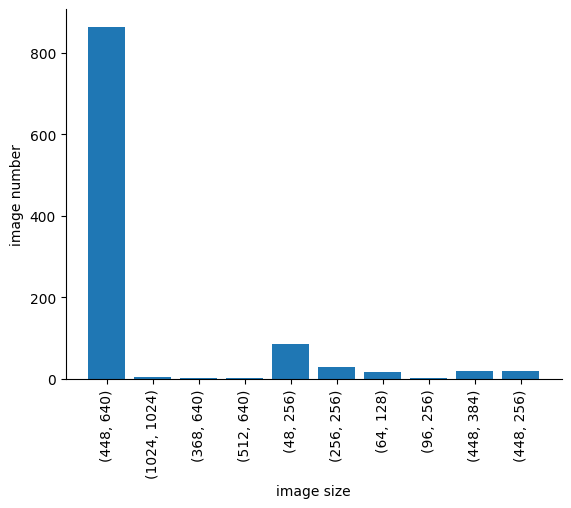

In [6]:
camera_data = load_camera_data()

# plot image size histogram
sizes = [data.sizes["shot_id"] for data in camera_data.values()]
plt.bar([str(key) for key in camera_data], sizes)
plt.xlabel('image size')
plt.ylabel('image number')
plt.xticks(rotation=90)
sns.despine()

In [7]:
test_size = 0.3  # fraction of dataset to use for testing
dataset = load_camera_data()[(448, 640)]
dataset = dataset.drop_vars(["time", "shot_id"])  # anonymize dataset 

# shuffle dataset
shot_index = np.arange(dataset.sizes["shot_id"], dtype=int)
rng = np.random.default_rng(7)
rng.shuffle(shot_index)
test_split = int(np.floor(test_size * dataset.sizes["shot_id"]))

train = dataset.isel(shot_id=shot_index[test_split:])
test = dataset.isel(shot_id=shot_index[:test_split])
solution = test.volume.to_pandas().to_frame()
rng.random(len(solution))
solution["Usage"] = np.where(rng.random(len(solution)) < 0.5, "Public", "Private")

test = test.drop_vars("volume")  # drop target from test dataset

# write datasets to file
path = pathlib.Path().absolute().parent / "fair_mast_data/plasma_volume"
train.to_netcdf(path / "train.nc")
test.to_netcdf(path / "test.nc")
solution.to_csv(path / "solution.csv")